<a href="https://colab.research.google.com/github/EdnaEze/Sentiment-Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets torch

# Import Libraries

In [2]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Load Dataset

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Deep Learning/tripadvisor_hotel_reviews.csv')
dataset.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
dataset['Rating'].nunique()

5

In [6]:
dataset['Rating'].unique()

array([4, 2, 3, 5, 1])

In [7]:
# Encode and name ratings into positive, neutral and negative sentiments

def ratings_encode(x):
  if x == 2 or x == 1:
    return 0
  if x == 3:
    return 1
  if x == 4 or x == 5:
    return 2

def ratings2name(x):
  if x == 0:
    return "Negative"
  if x == 1:
    return "Neutral"
  if x == 2:
    return "Positive"

dataset['labels'] = dataset['Rating'].apply(ratings_encode)
dataset['label_name'] = dataset['labels'].apply(ratings2name)
dataset.head()

,Review,Rating,labels,label_name
0,nice hotel expensive parking got good deal sta...,4,2,Positive
1,ok nothing special charge diamond member hilto...,2,0,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral
3,"unique, great stay, wonderful time hotel monac...",5,2,Positive
4,"great stay great stay, went seahawk game aweso...",5,2,Positive


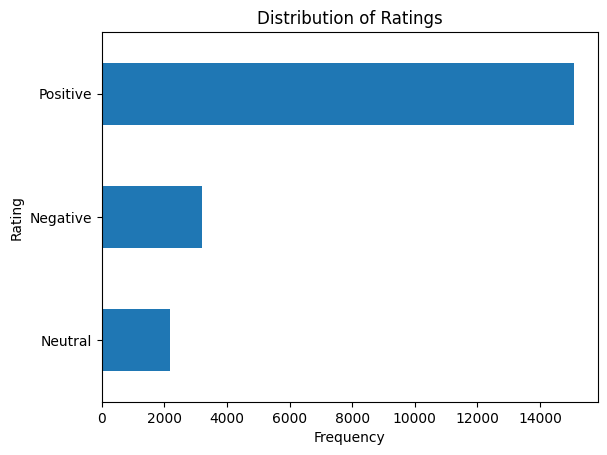

In [8]:
dataset["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Distribution of Ratings")
plt.xlabel("Frequency")
plt.ylabel("Rating")
plt.show()

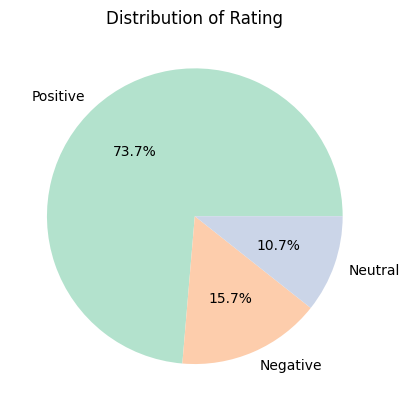

In [9]:
# Count the occurrences of each label
Rating_counts = dataset['label_name'].value_counts()
# Create a pie chart
plt.pie(Rating_counts, labels=Rating_counts.index, colors = plt.cm.Pastel2.colors, autopct='%1.1f%%')
plt.title('Distribution of Rating')
plt.show()


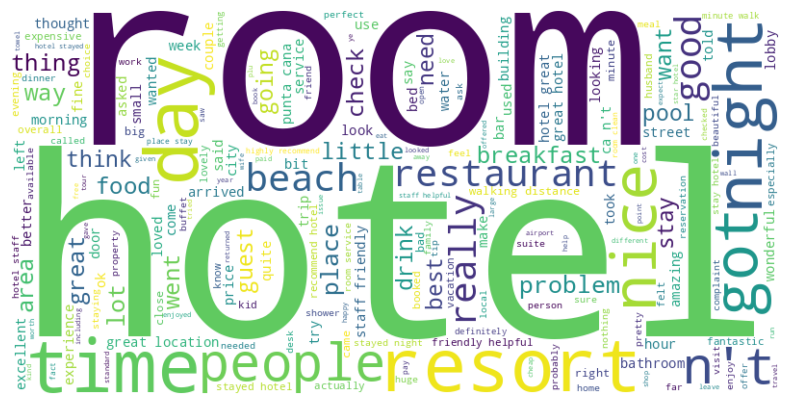

In [10]:
# Join all reviews into a single string
all_reviews = ' '.join(dataset['Review'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, prefer_horizontal=0.3, background_color='white', stopwords=STOPWORDS).generate(all_reviews)

# Display the image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Lenght of Reviews

Transformer models have a maximum input sequence length that is referred to as the **maximum context size**. For applications using DistilBERT, the maximum context size is 512 tokens, which amounts to a few paragraphs of text.

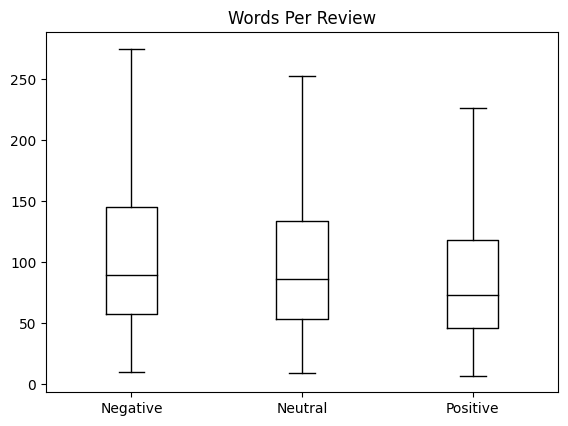

In [11]:
dataset["Words Per Review"] = dataset["Review"].str.split().apply(len)
dataset.boxplot("Words Per Review", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each Rating most reviews are around 80 words long and the longest reviews are well below DistilBERT's maximum context size. Texts that are longer than a model's context size need to be truncated, which can lead to a loss in performance if the truncated text contains crucial information; in this case, it looks like that won't be an issue.

In [12]:
dataset = dataset.drop(['Words Per Review'], axis=1)
dataset.head(3)

,Review,Rating,labels,label_name
0,nice hotel expensive parking got good deal sta...,4,2,Positive
1,ok nothing special charge diamond member hilto...,2,0,Negative
2,nice rooms not 4* experience hotel monaco seat...,3,1,Neutral


# Tokenization

Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus.

In [13]:
# First convert pandas dataframe to Hugging face dataset object
dataset = Dataset.from_pandas(dataset)

In [14]:
dataset

Dataset({
    features: ['Review', 'Rating', 'labels', 'label_name'],
    num_rows: 20491
})

In [15]:
# df = dataset.train_test_split(test_size=0.1)
# print(df)

In [16]:
#Create train, test and validation dataset
from datasets import DatasetDict

df_train_valid = dataset.train_test_split(test_size=0.09)
df_train = df_train_valid['train'].train_test_split(test_size=0.11)
dataset = {'train': df_train['train'], 'validation': df_train['test'], 'test': df_train_valid['test']}

dataset = DatasetDict(dataset)
dataset

DatasetDict({
    train: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 16594
    })
    validation: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 2052
    })
    test: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 1845
    })
})

### Subword Tokenization

The function below applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model's maximum context size. To see tokenize()

In [17]:
# Load tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define a function to tokenize and preprocess the text
def tokenize(batch):
  return tokenizer(batch["Review"], truncation=True, padding='max_length', max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [18]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 16594
    })
    validation: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 2052
    })
    test: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name'],
        num_rows: 1845
    })
})

In [19]:
# Apply the preprocessing function across all splits in the dataset
encoded_dataset = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16594 [00:00<?, ? examples/s]

Map:   0%|          | 0/2052 [00:00<?, ? examples/s]

Map:   0%|          | 0/1845 [00:00<?, ? examples/s]

In [20]:
print(encoded_dataset["train"].column_names)

['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask']


# Training the Text Classifier

### Load the weights of Pretrained model

In [21]:
# Specify the model checkpoint
model_ckpt = "distilbert-base-uncased"

# Determine if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the DistilBERT model and move it to the selected device
model = DistilBertModel.from_pretrained(model_ckpt).to(device)

### Extract hidden state

In [22]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [23]:
#Convert input_ids and attention_mask to torch format(tensors)

encoded_dataset.set_format("torch",
                            columns=["input_ids", "attention_mask", "labels"])

In [24]:
#Extract all hidden states across all splits

df_hidden = encoded_dataset.map(extract_hidden_states, batched=True, batch_size=32)

Map:   0%|          | 0/16594 [00:00<?, ? examples/s]

Map:   0%|          | 0/2052 [00:00<?, ? examples/s]

Map:   0%|          | 0/1845 [00:00<?, ? examples/s]

In [25]:
df_hidden["train"].column_names

['Review',
 'Rating',
 'labels',
 'label_name',
 'input_ids',
 'attention_mask',
 'hidden_state']

In [26]:
df_hidden

DatasetDict({
    train: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16594
    })
    validation: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2052
    })
    test: Dataset({
        features: ['Review', 'Rating', 'labels', 'label_name', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1845
    })
})

## Creating a feature matrix

In [27]:
import numpy as np

X_train = np.array(df_hidden["train"]["hidden_state"])
X_val = np.array(df_hidden["validation"]["hidden_state"])
y_train = np.array(df_hidden["train"]["labels"])
y_val = np.array(df_hidden["validation"]["labels"])
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16594, 768), (2052, 768), (16594,), (2052,))

In [28]:
y_val

array([2, 2, 2, ..., 2, 2, 2])

## Training a simple classifier

In [29]:
lr_clf = LogisticRegression(max_iter = 3000, random_state=42)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000, random_state=42)

In [30]:
lr_clf.score(X_val, y_val)

0.8377192982456141

Looking at the accuracy, it might appear the model has a high accuracy, but, we can only tell how well it did by looking comparing it to a baseline and looking at the confusion matrix.

### Compare to a dummy classifier

The dummy classifier is used to build a classifier with simple heuristics.

In [31]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy= "most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

dummy_clf.score(X_val, y_val)

0.7339181286549707

Given the accuracy result from the dummy classifier we can say the logistics regression classifier with DistilBERT embeddings is better than the baseline/dummy classifier.

### Investigate performance with confusion matrix

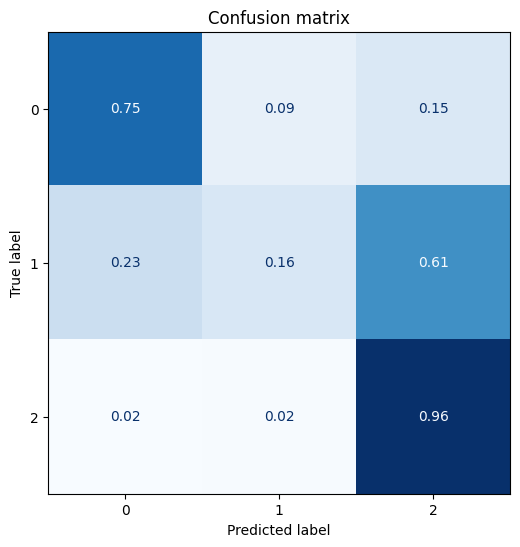

In [32]:
def plot_confusion_matrix(y_preds, y_true):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_val)
plot_confusion_matrix(y_preds, y_val)

From the confusion we can see that the model was able to predict positive review (labeled **2** in the confusuion matrix) correctly to high degree (**0.96**). The model had the most difficulty predicting the neutral review (labeled **1**). It was mostly misclassified as a positive review.

# Fine-Tuning Transformers

With fine-tuning approach the hidden states are not used as fixed features, instead they are trained. Training the hidden states that serve as inputs to the classification model will help avoid the problem of working with dat that may not be well suited for classification tasks. Instead, the initial hidden states adapt during training to decress the model loss and this increase performance.

## Loading pretrained model

In [33]:
#from transformers import AutoModelForSequenceClassification
from transformers import DistilBertForSequenceClassification


num_classes = 3
# model = (AutoModelForSequenceClassification
#          .from_pretrained(model_ckpt, num_labels=num_labels)
#          .to(device))

model = (DistilBertForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_classes)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Define performance metrics

In [35]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

## Train the model

In [36]:
from huggingface_hub import notebook_login

notebook_login()

#### Traing Parameters

In [45]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(encoded_dataset["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-tripadvisor"

training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=2
                                  )

#### Instantiate and fine-tune model with 'Trainer'

In [46]:
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_dataset["train"],
                  eval_dataset=encoded_dataset["validation"],
                  tokenizer=tokenizer)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.346030,0.862573,0.864945
2,0.225600,0.346743,0.872807,0.869175


TrainOutput(global_step=1038, training_loss=0.2255001371880717, metrics={'train_runtime': 604.877, 'train_samples_per_second': 54.867, 'train_steps_per_second': 1.716, 'total_flos': 4396406428864512.0, 'train_loss': 0.2255001371880717, 'epoch': 2.0})

In [47]:
preds_output =  trainer.predict(encoded_dataset["validation"])

In [48]:
preds_output.metrics

{'test_loss': 0.3467428684234619,
 'test_accuracy': 0.8728070175438597,
 'test_f1': 0.8691753453969281,
 'test_runtime': 13.0172,
 'test_samples_per_second': 157.638,
 'test_steps_per_second': 9.91}

In [51]:
y_preds = np.argmax(preds_output.predictions, axis=1)

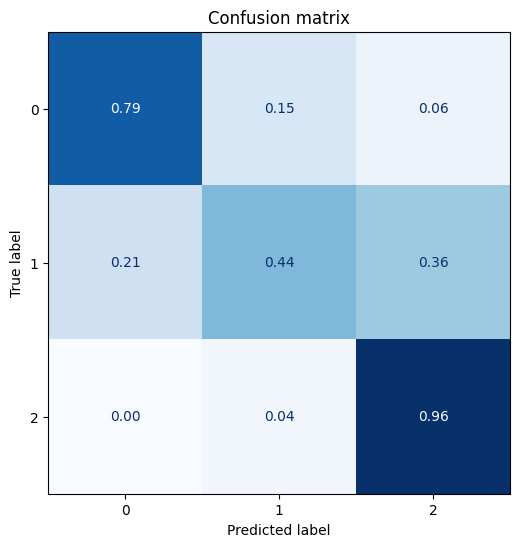

In [54]:
plot_confusion_matrix(y_preds, y_val)

From the confusion matrix, we can see the model did well in predicting the the positive review - **0.96** and the negative neview - **0.79**. In comparison to the confusion matrix from the logistic regression classifier, the model was better at predicting the neutral class -
**0.44** unlike in logistics regression which had a score of **0.16**.

# Error Analysis

Sort validation samples by model loss.

In [59]:
from torch.nn.functional import cross_entropy

def foward_pass_with_label(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
           if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["labels"].to(device),
                         reduction="none")

  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [60]:
#convert dataset back to pytorch tensors
encoded_dataset.set_format("torch",
                           columns=["input_ids", "attention_mask", "labels"])

In [61]:
#compute loss values
encoded_dataset["validation"] = encoded_dataset["validation"].map(
    foward_pass_with_label,
    batched=True,
    batch_size=16)

Map:   0%|          | 0/2052 [00:00<?, ? examples/s]

### Create Dataframe with tests, losses and predicted and true labels

This enables us sort encoded dataset by the losses in either ascending or descending order.

In [69]:
encoded_dataset.set_format("pandas")

cols = ["Review", "labels", "predicted_label", "loss"]
df_test = encoded_dataset["validation"][:][cols]
df_test["labels"] = df_test["labels"].apply(ratings2name)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(ratings2name))

In [75]:
#Dataset with highest losses
df_test.sort_values("loss", ascending=False).head(10)

,Review,labels,predicted_label,loss
348,"great hotel recently stayed hotel, position cl...",Neutral,Positive,6.375383
1148,"loved hotel beware spent 3 nights hotel july, ...",Negative,Positive,6.225467
1745,"great vacation stayed week jan 19 jan 26/08, w...",Neutral,Positive,6.158932
1686,great husband visited majestic colonial august...,Neutral,Positive,6.071301
1161,"location location location sydney tour 5 days,...",Positive,Negative,5.754317
2004,time resort type trip time traveller inclusive...,Positive,Negative,5.567095
1617,better hotels amenities nice staff not excepti...,Neutral,Positive,5.457201
1986,"loved location, location hotel great, room mat...",Neutral,Positive,5.353335
836,ehhhh chose silvermine closest hotel airport a...,Negative,Positive,5.333061
614,"stay stayed days december 2006 come, liked hot...",Neutral,Positive,5.263073


It can be clearly seen that the model predicted some of the labels incorrectly. On the other hand, it seems that there are quite a few examples which might have beeen mislabeled. In particular: Neutral seems to have been mislabelled several times. With this information, the dataset can be refined which often leads to big performance gains as having more data or larger models.

In [73]:
#Dataset with lowest losses
df_test.sort_values("loss", ascending=True).head(10)

,Review,labels,predicted_label,loss
1669,fantastic boutique hotel near montparnasse wow...,Positive,Positive,0.001703
1143,fabulous hotel great location superb housekeep...,Positive,Positive,0.001774
1508,best hotel world stayed world continue feel ho...,Positive,Positive,0.001782
1891,great hotel middle madrid just madrid celebrat...,Positive,Positive,0.001795
1972,amazing hotel believe good reviews hotel fanta...,Positive,Positive,0.001808
1445,exceeded expecations husband traveled europe 4...,Positive,Positive,0.001836
512,best italy accommodations perfect location get...,Positive,Positive,0.001843
8,hotel gem location owners staff cleanliness am...,Positive,Positive,0.001855
101,"best hotel el covento beautyful hotel know, st...",Positive,Positive,0.001856
1146,best hotels world stayed valley wing shangri l...,Positive,Positive,0.001858


When looking at the samples with lowest losses, we observe that the model seems to be most confident when predicting the **positive** class.

# Saving and Sharing Model

In [77]:
trainer.push_to_hub(commit_message="Training completed")

events.out.tfevents.1725263328.5b038ad7c78f.8413.4:   0%|          | 0.00/6.34k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ednahf/distilbert-base-uncased-finetuned-tripadvisor/commit/7bdc2643f7239a36ee0bff21bc4909d4e341c542', commit_message='Training completed', commit_description='', oid='7bdc2643f7239a36ee0bff21bc4909d4e341c542', pr_url=None, pr_revision=None, pr_num=None)

In [78]:
from transformers import pipeline

model_id = "ednahf/distilbert-base-uncased-finetuned-tripadvisor"
classifier = pipeline("sentiment-analysis", model=model_id)


config.json:   0%|          | 0.00/769 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [81]:
custom_review = "The room in this hotel was so small and bad. I am really disappointed"
preds = classifier(custom_review, return_all_scores=True)

In [101]:
preds

[[{'label': 'LABEL_0', 'score': 0.816653847694397},
  {'label': 'LABEL_1', 'score': 0.13722360134124756},
  {'label': 'LABEL_2', 'score': 0.046122487634420395}]]

# Conclusion

The models performance is satisfactory overall. To achieve better performance, cleaning the data or injecting similar examples can make the model more robust.